Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import cv2
print(tf.__version__) 
import warnings
warnings.filterwarnings('ignore')

2.11.0


In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/CNN_assignment1/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/CNN_assignment1/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2249
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2249 files belonging to 9 classes.
Using 1800 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2249 files belonging to 9 classes.
Using 449 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

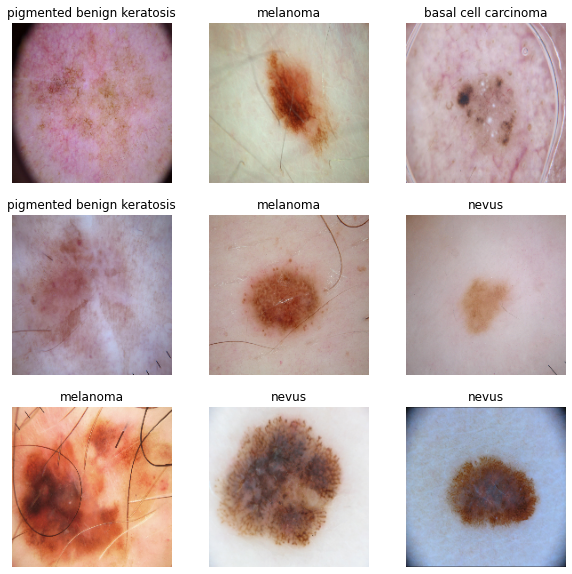

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout
from tensorflow.keras.layers import BatchNormalization,Flatten,Dense,Activation
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]
num_classes = len(class_names)
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

## Summary of all 9 classes
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       36992     
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### Todo, choose an appropirate optimiser and loss function

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       36992     
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 509s 2s/step - loss: 3.6367 - accuracy: 0.3383 - val_loss: 2.2146 - val_accuracy: 0.2004
Epoch 2/20
57/57 [==============================] - 5s 94ms/step - loss: 1.4886 - accuracy: 0.4928 - val_loss: 2.1621 - val_accuracy: 0.1715
Epoch 3/20
57/57 [==============================] - 5s 93ms/step - loss: 1.3506 - accuracy: 0.5394 - val_loss: 2.1002 - val_accuracy: 0.1982
Epoch 4/20
57/57 [==============================] - 5s 95ms/step - loss: 1.2539 - accuracy: 0.5672 - val_loss: 2.1551 - val_accuracy: 0.1537
Epoch 5/20
57/57 [==============================] - 5s 93ms/step - loss: 1.1605 - accuracy: 0.5928 - val_loss: 2.1083 - val_accuracy: 0.1871
Epoch 6/20
57/57 [==============================] - 5s 93ms/step - loss: 1.0356 - accuracy: 0.6322 - val_loss: 1.9868 - val_accuracy: 0.3118
Epoch 7/20
57/57 [==============================] - 5s 95ms/step - loss: 0.9444 - accuracy: 0.6650 - val_loss: 1.8982 - val_accuracy: 0.3274
Epoch 8/20
57

### Visualizing training results

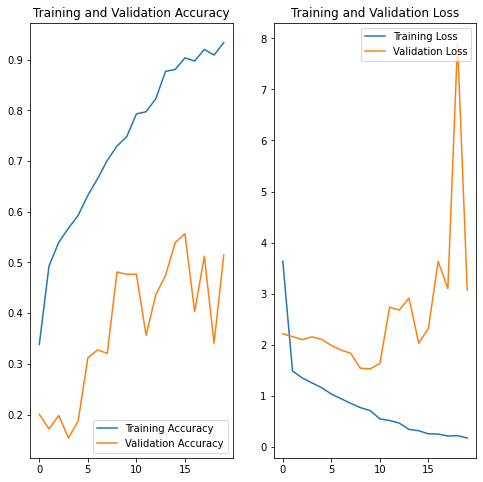

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**You can see in the above images that there exists model overfitting. There is visible difference between the Training accuracy and Validation Accuracy.
Due to small dataset, model memorises most of data and shows Overfitting.
There is also visible difference between Training Loss and Validation Loss.** 

In [ ]:
for image_class in class_names:
    n_images_per_class = len(list(data_dir_train.joinpath(image_class).glob('*.jpg')))
    print(f'No. of images for the class {image_class} is {n_images_per_class} ( {(n_images_per_class/image_count_train)*100:.2f} % of total images)')

No. of images for the class actinic keratosis is 114 ( 5.07 % of total images)
No. of images for the class basal cell carcinoma is 376 ( 16.72 % of total images)
No. of images for the class dermatofibroma is 95 ( 4.22 % of total images)
No. of images for the class melanoma is 438 ( 19.48 % of total images)
No. of images for the class nevus is 357 ( 15.87 % of total images)
No. of images for the class pigmented benign keratosis is 462 ( 20.54 % of total images)
No. of images for the class seborrheic keratosis is 77 ( 3.42 % of total images)
No. of images for the class squamous cell carcinoma is 191 ( 8.49 % of total images)
No. of images for the class vascular lesion is 139 ( 6.18 % of total images)


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomCrop(32, 32)
  ]
)

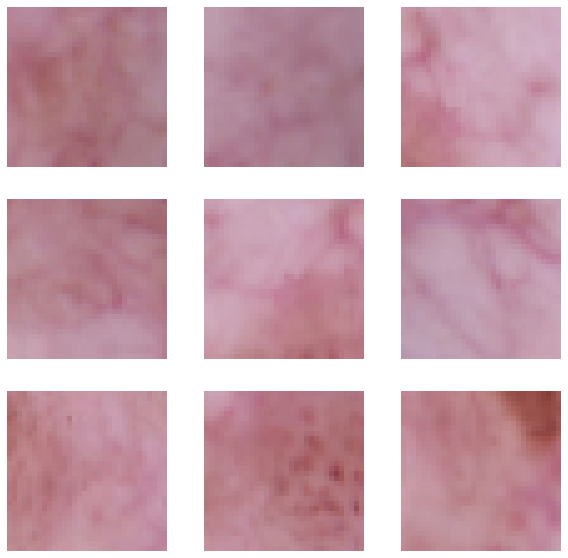

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
    

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])


### Compiling the model

In [ ]:
## Your code goes here
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 rescaling_2 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


57/57 [==============================] - 21s 204ms/step - loss: 2.0552 - accuracy: 0.2072 - val_loss: 2.0112 - val_accuracy: 0.2004
Epoch 2/20
57/57 [==============================] - 11s 196ms/step - loss: 1.9948 - accuracy: 0.2356 - val_loss: 1.9004 - val_accuracy: 0.3274
Epoch 3/20
57/57 [==============================] - 11s 197ms/step - loss: 1.9263 - accuracy: 0.2661 - val_loss: 1.8011 - val_accuracy: 0.3252
Epoch 4/20
57/57 [==============================] - 11s 199ms/step - loss: 1.8007 - accuracy: 0.3300 - val_loss: 1.7267 - val_accuracy: 0.3363
Epoch 5/20
57/57 [==============================] - 11s 196ms/step - loss: 1.7788 - accuracy: 0.3344 - val_loss: 1.6963 - val_accuracy: 0.3274
Epoch 6/20
57/57 [==============================] - 11s 197ms/step - loss: 1.7925 - accuracy: 0.3217 - val_loss: 1.6860 - val_accuracy: 0.3541
Epoch 7/20
57/57 [==============================] - 11s 197ms/step - loss: 1.7307 - accuracy: 0.3533 - val_loss: 1.6740 - val_accuracy: 0.3363
Epoch 8/20

### Visualizing the results

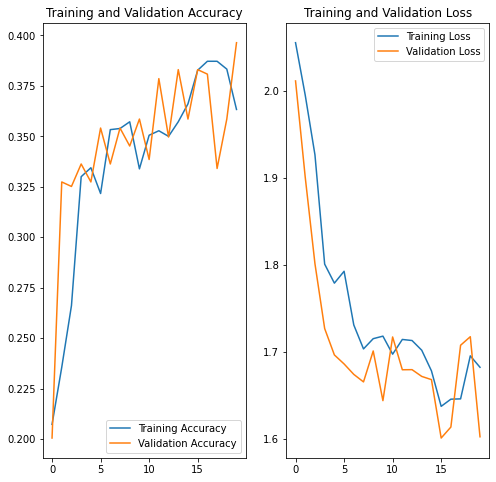

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**It seems that the model shows some improvement compared to previous model. The model is underfitting now. The Training accuracy and Validation accuracy seems to good comparatively previously.**

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.
for image_class in class_names:
    n_images_per_class = len(list(data_dir_train.joinpath(image_class).glob('*.jpg')))
    print(f'No. of images for the class {image_class} is {n_images_per_class} ( {(n_images_per_class/image_count_train)*100:.2f} % of total images)')

No. of images for the class actinic keratosis is 114 ( 5.07 % of total images)
No. of images for the class basal cell carcinoma is 376 ( 16.72 % of total images)
No. of images for the class dermatofibroma is 95 ( 4.22 % of total images)
No. of images for the class melanoma is 438 ( 19.48 % of total images)
No. of images for the class nevus is 357 ( 15.87 % of total images)
No. of images for the class pigmented benign keratosis is 462 ( 20.54 % of total images)
No. of images for the class seborrheic keratosis is 77 ( 3.42 % of total images)
No. of images for the class squamous cell carcinoma is 191 ( 8.49 % of total images)
No. of images for the class vascular lesion is 139 ( 6.18 % of total images)


#### **Todo:** Write your findings here: 

#### - Which class has the least number of samples?
#### ->> seborrheic keratosis has the least number of samples.

#### - Which classes dominate the data in terms proportionate number of samples?
#### ->> benign keratosis(20.54&) and melanoma(19.48%) are the classes with most number of images.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset = "/content/gdrive/MyDrive/CNN_assignment1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC4A7505E20>: 100%|██████████| 500/500 [00:19<00:00, 25.08 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC4A7588D00>: 100%|██████████| 500/500 [00:25<00:00, 19.83 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC4A76D8640>: 100%|██████████| 500/500 [00:26<00:00, 18.66 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC4A74E3220>: 100%|██████████| 500/500 [01:46<00:00,  4.70 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7FC4A74E3A90>: 100%|██████████| 500/500 [01:34<00:00,  5.31 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC51C6E1040>: 100%|██████████| 500/500 [00:19<00:00, 25.75 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FC4A76D8640>: 100%|██████████| 500/500 [00:46<00:00, 10.84 Samples/s]


Initialised with 191 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC51C20E430>: 100%|██████████| 500/500 [00:20<00:00, 23.94 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_assignment1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC4A75E4C40>: 100%|██████████| 500/500 [00:25<00:00, 19.71 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN_assignment1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032247.jpg_9e44d04b-e24d-47c7-a3ac-55048a784f63.jpg',
 '/content/gdrive/MyDrive/CNN_assignment1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027876.jpg_c25872bd-5c82-4af3-b8ce-42a73645f21c.jpg',
 '/content/gdrive/MyDrive/CNN_assignment1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025771.jpg_076816a7-8f94-46d6-b30a-46a8deaa8938.jpg',
 '/content/gdrive/MyDrive/CNN_assignment1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0026417.jpg_9d2827a3-344f-4274-b2aa-28d0bb6c3006.jpg',
 '/content/gdrive/MyDrive/CNN_assignment1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/derm

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df=df2

In [ ]:
new_df['Label'].value_counts()

dermatofibroma                500
vascular lesion               500
seborrheic keratosis          500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
melanoma                      500
pigmented benign keratosis    500
squamous cell carcinoma       500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="/content/gdrive/MyDrive/CNN_assignment1/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here
model=Sequential([
    # data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3)),
    layers.Conv2D(32,(3,3),activation='relu',padding='same'),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(128,(3,3),activation='relu',padding='same'),
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.3),
    
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),   
    layers.Dense(9, activation='softmax')
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_15 (Conv2D)          (None, 178, 178, 64)      18496     
                                                                 
 batch_normalization_4 (Batc  (None, 178, 178, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 89, 89, 64)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 89, 89, 64)       

#### **Todo:**  Train your model

In [ ]:
epochs = 50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 57s 305ms/step - loss: 6.7171 - accuracy: 0.2604 - val_loss: 4.5710 - val_accuracy: 0.1416
Epoch 2/50
169/169 [==============================] - 49s 285ms/step - loss: 2.2373 - accuracy: 0.2941 - val_loss: 2.2975 - val_accuracy: 0.1660
Epoch 3/50
169/169 [==============================] - 49s 276ms/step - loss: 1.8739 - accuracy: 0.3337 - val_loss: 5.1530 - val_accuracy: 0.1082
Epoch 4/50
169/169 [==============================] - 50s 289ms/step - loss: 1.6940 - accuracy: 0.3802 - val_loss: 1.8942 - val_accuracy: 0.2913
Epoch 5/50
169/169 [==============================] - 50s 286ms/step - loss: 1.5588 - accuracy: 0.4324 - val_loss: 1.4164 - val_accuracy: 0.5093
Epoch 6/50
169/169 [==============================] - 48s 275ms/step - loss: 1.4221 - accuracy: 0.4756 - val_loss: 1.3851 - val_accuracy: 0.5033
Epoch 7/50
169/169 [==============================] - 50s 286ms/step - loss: 1.3779 - accuracy: 0.4965 - val_loss: 3.4503 - val_ac

#### **Todo:**  Visualize the model results

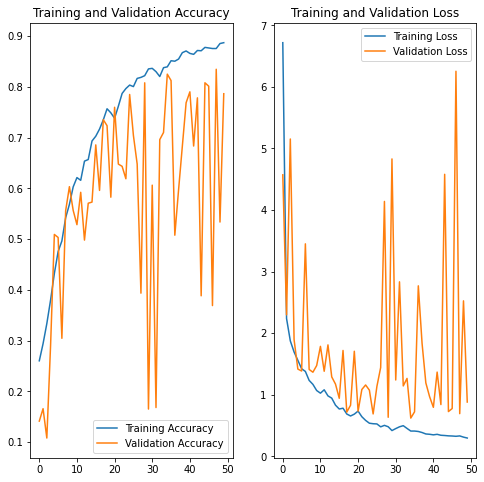

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**The results are comparatively better than the previous model.The problem of overfitting and underfitting has been addressed to an extent very carefully. The accuracy of Validation and Training has been improved and same happens for the Training Loss and Validation Loss.**  

In [ ]:
model.save('melanoma_model.h5')

In [ ]:
model = tf.keras.models.load_model('melanoma_model.h5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_15 (Conv2D)          (None, 178, 178, 64)      18496     
                                                                 
 batch_normalization_4 (Batc  (None, 178, 178, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 89, 89, 64)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 89, 89, 64)       

In [ ]:
model.evaluate(train_ds)

169/169 [==============================] - 31s 171ms/step - loss: 0.1969 - accuracy: 0.9313


[0.19693675637245178, 0.9312962889671326]

In [ ]:
model.evaluate(val_ds)

43/43 [==============================] - 8s 151ms/step - loss: 0.8810 - accuracy: 0.7865


[0.8809555768966675, 0.7865085005760193]

**The Training accuracy of final model is 93.13% and Validation accuracy of final model is 78.65%.**